In [1]:
import numpy as np
import os.path
from sklearn.decomposition import PCA
import multiprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost


In [2]:
##get label and feature set
cebp_tfbs_label=[]
cebp_dist_tss_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.hg19.narrow_peaks_1_overlap.bed','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if int(splitline[8]) > 1:
            cebp_tfbs_label.append(1)
        else:
            cebp_tfbs_label.append(int(splitline[8]))
        cebp_dist_tss_list.append(int(splitline[7]))
cebp_tfbs_label = np.array(cebp_tfbs_label, dtype='int32')
cebp_dist_tss_list = np.array(cebp_dist_tss_list, dtype='int32')


In [3]:
cebp_gch_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.IMR90_GCH_signal.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA':
            cebp_gch_list.append(float('nan'))
        else:
            cebp_gch_list.append(float(splitline[4]))
cebp_gch_list = np.array(cebp_gch_list, dtype='float32')


In [4]:
cebp_hcg_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.IMR90_HCG_signal.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA':
            cebp_hcg_list.append(float('nan'))
        else:
            cebp_hcg_list.append(float(splitline[4]))
cebp_hcg_list = np.array(cebp_hcg_list, dtype='float32')

In [5]:
cebp_dnase_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.IMR90_DNase_signal.E017.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA':
            cebp_dnase_list.append(float('nan'))
        else:
            cebp_dnase_list.append(float(splitline[4]))
cebp_dnase_list = np.array(cebp_dnase_list, dtype='float32')



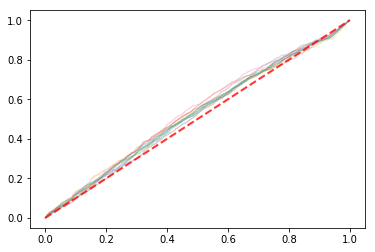

In [6]:
from scipy import stats
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
from numpy import interp
import matplotlib.pyplot as plt
random_state=0
#cebp_bin_dist_tss_list=cebp_dist_tss_list
#cebp_bin_dist_tss_list[cebp_bin_dist_tss_list>2000]=1
#cebp_bin_dist_tss_list[cebp_bin_dist_tss_list<=2000]=0

#X = np.column_stack((cebp_gch_list[~np.isnan(cebp_gch_list)],np.log10(cebp_dist_tss_list[~np.isnan(cebp_gch_list)]+1)))
#X = np.column_stack((cebp_gch_list[~np.isnan(cebp_gch_list)],cebp_bin_dist_tss_list[~np.isnan(cebp_gch_list)]))
#X = np.column_stack((cebp_gch_list[~np.isnan(cebp_gch_list)],np.nan_to_num(cebp_hcg_list[~np.isnan(cebp_gch_list)])))
X = stats.zscore(cebp_gch_list[~np.isnan(cebp_gch_list)]).reshape(-1,1)
#X = stats.zscore(np.nan_to_num(cebp_dnase_list[~np.isnan(cebp_gch_list)])).reshape(-1,1)
#X = stats.zscore(np.nan_to_num(cebp_hcg_list[~np.isnan(cebp_gch_list)])).reshape(-1,1)
y = cebp_tfbs_label[~np.isnan(cebp_gch_list)]

cv = StratifiedKFold(n_splits=10)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=50)
#classifier = svm.SVC(kernel='rbf', probability=True,
#                     random_state=random_state)
#classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=500, objective='binary:logistic',reg_alpha=0.5,reg_lambda=0.5,subsample=0.667,n_jobs=4)
#classifier = SVC(C=1.0, kernel='linear', gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=random_state, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None)
#classifier = LogisticRegression(penalty='elasticnet', dual=False, tol=0.0001, C=0.0001, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=random_state, solver='saga', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)



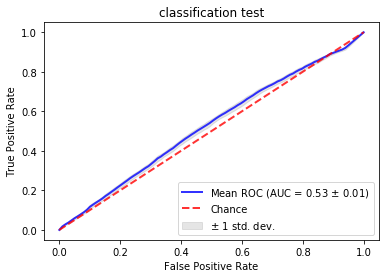

In [7]:
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('classification test')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.show()



In [8]:
###try different way
cebp_tfbs_label=[]
cebp_dist_tss_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.hg19.optimalIDR_peaks_overlap.distal_to_TSS.chr1.b37.bed','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if int(splitline[6]) > 1:
            cebp_tfbs_label.append(1)
        else:
            cebp_tfbs_label.append(int(splitline[6]))
        cebp_dist_tss_list.append(int(splitline[7]))
cebp_tfbs_label = np.array(cebp_tfbs_label, dtype='int32')
cebp_dist_tss_list = np.array(cebp_dist_tss_list, dtype='int32')


In [21]:
cebp_global_zscore_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_global_zscore.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_global_zscore_list.append(float('nan'))
        else:
            cebp_global_zscore_list.append(float(splitline[4]))
cebp_global_zscore_list = np.nan_to_num(np.array(cebp_global_zscore_list, dtype='float32'))

cebp_local1_zscore_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_local1_zscore.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_local1_zscore_list.append(float('nan'))
        else:
            cebp_local1_zscore_list.append(float(splitline[4]))
cebp_local1_zscore_list = np.nan_to_num(np.array(cebp_local1_zscore_list, dtype='float32'))

cebp_local2_zscore_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_local2_zscore.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_local2_zscore_list.append(float('nan'))
        else:
            cebp_local2_zscore_list.append(float(splitline[4]))
cebp_local2_zscore_list = np.nan_to_num(np.array(cebp_local2_zscore_list, dtype='float32'))

cebp_global_binomial_p_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_global_binomial_p.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_global_binomial_p_list.append(float('nan'))
        else:
            cebp_global_binomial_p_list.append(float(splitline[4]))
cebp_global_binomial_p_list = np.nan_to_num(np.array(cebp_global_binomial_p_list, dtype='float32'))

cebp_local1_binomial_p_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_local1_binomial_p.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_local1_binomial_p_list.append(float('nan'))
        else:
            cebp_local1_binomial_p_list.append(float(splitline[4]))
cebp_local1_binomial_p_list = np.nan_to_num(np.array(cebp_local1_binomial_p_list, dtype='float32'))

cebp_local2_binomial_p_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.chr1.IMR90_local2_binomial_p.DNA_IMR90_rep2_merged.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_local2_binomial_p_list.append(float('nan'))
        else:
            cebp_local2_binomial_p_list.append(float(splitline[4]))
cebp_local2_binomial_p_list = np.nan_to_num(np.array(cebp_local2_binomial_p_list, dtype='float32'))

cebp_gcbias_list=[]
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/CEBPB.fimo.CEBPB_ext_100.gcbias.b37.alignedTo.CEBPB.1200.1.txt','r') as f:
    for line in f:
        line=line.rstrip('\n')
        splitline = line.split("\t")
        if splitline[4] == 'NA' or splitline[4] == 'inf':
            cebp_gcbias_list.append(float('nan'))
        else:
            cebp_gcbias_list.append(float(splitline[4]))
cebp_gcbias_list = np.nan_to_num(np.array(cebp_gcbias_list, dtype='float32'))



/Users/yaping/anaconda3/envs/bisulfitehic/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yaping/anaconda3/envs/bisulfitehic/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yaping/anaconda3/envs/bisulfitehi

[11:42:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

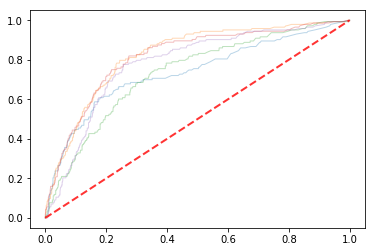

In [28]:
from scipy import stats
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
from numpy import interp
import matplotlib.pyplot as plt
random_state=0

#X = np.column_stack((cebp_global_zscore_list,cebp_local1_zscore_list,cebp_local2_zscore_list,cebp_global_binomial_p_list,cebp_local1_binomial_p_list,cebp_local2_binomial_p_list, cebp_gcbias_list))
X = cebp_gcbias_list.reshape(-1, 1)
y = cebp_tfbs_label

cv = StratifiedKFold(n_splits=5)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=50)
#classifier = svm.SVC(kernel='rbf', probability=True,
#                     random_state=random_state)
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=500, objective='binary:logistic',reg_alpha=0.5,reg_lambda=0.5,subsample=0.667,n_jobs=4)
#classifier = SVC(C=1.0, kernel='linear', gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
#classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=random_state, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None)
#classifier = LogisticRegression(penalty='elasticnet', dual=False, tol=0.0001, C=0.0001, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=random_state, solver='saga', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)


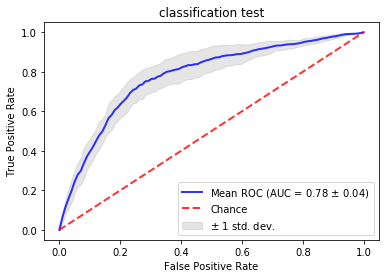

In [29]:
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('classification test')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.show()



In [12]:
X.shape
y.shape

(5684,)